# Topic Modeling

- we want to perform topic modeling on the test set
- we can perform the hyperparameter adjustment on validation set

In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import os
import numpy as np
import tqdm
from wordcloud import WordCloud
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim import models
from gensim.utils import ClippedCorpus

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd

## Data Preparation

### Data loading

In [2]:
path = './Dataset_TLDRHQ/dataset_topic_modeling/'

# train = []

for file in os.listdir(path):
    if 'val' in file:
        val = pd.read_json(f'{path}{file}', orient="records", lines=True)
        print(file)
    if 'test' in file:
        test = pd.read_json(f'{path}{file}', orient="records", lines=True)
        print(file)
    # if 'train' in file:
    #     temp = pd.read_json(f'{path}{file}', orient="records", lines=True)
    #     train.append(temp)
    #     print(file)

# train = pd.concat(train)

test.json
val.json


### Data Exploration - pre processing

In [3]:
test

,id,document_normalized,pos_tags
0,train-TLDR_RC_2018-10-cm-19097.json,"[danieldrepper, und, ich, hier, wir, sehen, be...","[NOUN, NOUN, VERB, ADJ, NOUN, NOUN, NOUN, ADV,..."
1,train-TLDR_RS_2013-03-21448.json,"[dating, since, august, last, year, one, point...","[VERB, ADP, NOUN, ADJ, NOUN, NUM, NOUN, NOUN, ..."
2,train-TLDR_RS_2012-04-12146.json,"[life, find, school, wing, chun, eager, learn,...","[NOUN, VERB, NOUN, VERB, NOUN, NOUN, VERB, VER..."
3,train-TLDR_RC_2018-10-cm-10081.json,"[mixed, chinese, malay, would, like, put, prim...","[ADJ, ADJ, NOUN, VERB, VERB, VERB, ADJ, NOUN, ..."
4,train-TLDR_RC_2013-04-cm-47367.json,"[make, sense, thought, renting, condo, apartme...","[NOUN, NOUN, VERB, VERB, ADJ, NOUN, VERB, VERB..."
...,...,...,...
40276,TLDR_RS_2020-05-cm-33121.json,"[recently, started, playing, battle, network, ...","[ADV, VERB, VERB, NOUN, NOUN, ADP, VERB, NUM, ..."
40277,TLDR_RS_2020-11-cm-29098.json,"[looking, buy, first, car, honestly, know, not...","[VERB, VERB, ADJ, NOUN, ADV, VERB, NOUN, ADJ, ..."
40278,TLDR_RS_2020-08-cm-29716.json,"[met, really, nice, girl, work, came, city, ri...","[VERB, ADV, ADJ, NOUN, NOUN, VERB, NOUN, ADV, ..."
40279,TLDR_RS_2020-11-cm-22864.json,"[first, series, rant, star, citizen, inconsist...","[ADJ, NOUN, NOUN, NOUN, ADJ, NOUN, NOUN, ADV, ..."


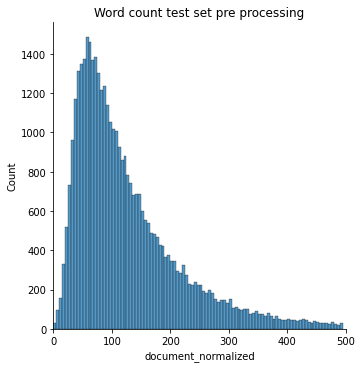

In [6]:
sns.displot(test['document_normalized'].apply(lambda x: len(x)), bins=range(0,500, 5)).set(title='Word count test set pre processing')
plt.xlim(0, 500)
plt.savefig('Images/word_count_pre.jpg')

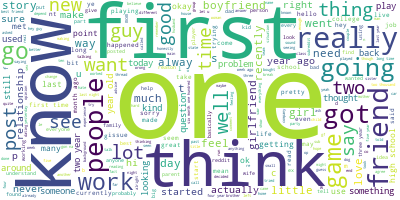

In [7]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(test['document_normalized'].to_string())

# Visualize the word cloud
wordcloud.to_file('Images/wordcloud_pre.png')
wordcloud.to_image()

### Data Processing

#### Verb and Noun filtering

In [4]:
col = []
for row in test.iterrows():
    a = []
    for i, elem in enumerate(row[1]['pos_tags']):
        if elem in ['NOUN', 'VERB']:
            a.append(row[1]['document_normalized'][i])

    col.append(a)

In [5]:
test['document_normalized'] = col

In [6]:
col = []
for row in val.iterrows():
    a = []
    for i, elem in enumerate(row[1]['pos_tags']):
        if elem in ['NOUN', 'VERB']:
            a.append(row[1]['document_normalized'][i])

    col.append(a)

In [7]:
val['document_normalized'] = col

#### Too frequent, infrequent and custom list words removal

In [8]:
stop_words = ['time', 'something', 'going', 'year', 'week', 'month', 'day', 'get', 'got', 'nt', 'want', 'know', 'thing', 'could', 'can', 'go', 'say', 'said']

test['document_normalized'] = test['document_normalized'].apply(lambda x: list(set(x)-set(stop_words)))

In [13]:
# test = test.loc[test['document_normalized'].apply(lambda x: len(x)) >= 5]

### Data exploration - post processing

(0.0, 500.0)

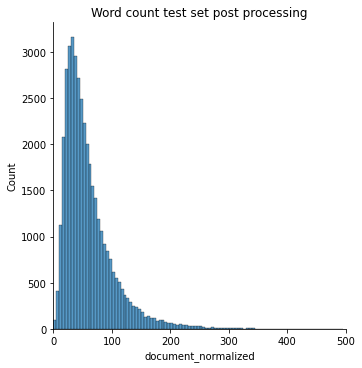

In [22]:
sns.displot(test['document_normalized'].apply(lambda x: len(x)), bins=range(0,500, 5)).set(title='Word count test set post processing')
plt.xlim(0, 500)
# plt.savefig('Images/word_count_post.jpg')

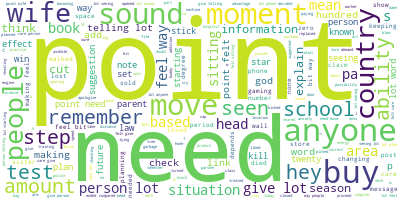

In [23]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(test['document_normalized'].to_string())

# Visualize the word cloud
# wordcloud.to_file('Images/wordcloud_post.png')
wordcloud.to_image()

In [11]:
word_number = 10
min_df = 10
max_df = 0.5

## LDA

### Word Embedding - BoW

In [9]:
# Create Dictionary
id2word = Dictionary(test['document_normalized'])

In [10]:
print('before filter:\t\t', len(id2word))
id2word.filter_extremes(no_below=min_df)
print('low filter:\t\t', len(id2word))
id2word.filter_extremes(no_above=max_df) # low threshold because there is a wide variety of topics
print('high and low filter:\t', len(id2word))

before filter:		 75861
low filter:		 13536
high and low filter:	 13536


In [11]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in test['document_normalized']] # (word, freq) for every document
# corpus_val = [id2word.doc2bow(text) for text in val['document_normalized']]

### Hyperaparameter tuning

In [12]:
temp = test.loc[test['document_normalized'].apply(lambda x: len(x)) >= 20]

In [13]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           alpha=a,
                                           eta=b)
    
    # coherence_model_lda = CoherenceModel(model=lda_model, corpus=corpus, coherence='umass')

    # print('inizio')
    coherence_model_lda = CoherenceModel(model=lda_model, texts=temp['document_normalized'], coherence='c_v').get_coherence()
    # print(coherence_model_lda)
    return coherence_model_lda

In [14]:
# Topics range
topics_range = [10, 20, 30, 40, 50, 60]
# topics_range = [5, 7, 20, 70, 150]
# topics_range = [10, 20, 30]

# Alpha parameter range (50/num_topics)
alpha_range = [0.01, 0.05, 0.1, 0.2, 0.5]
# alpha_range = [0.005, 0.01, 0.02, 1.2, 1.5, 2]
# alpha_range = [0.1]

# Beta parameter range
# beta_range = [0.05, 0.1, 0.2, 0.5, 0.7, 1, 1.5]
beta_range = [0.005, 0.01, 0.05, 0.1, 0.2]
# beta_range = [0.05]

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta_range)*len(alpha_range)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha_range:
                # iterare through beta values
                for b in beta_range:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word,
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    model_results = pd.DataFrame(model_results)
    pbar.close()

100%|██████████| 300/300 [4:35:36<00:00, 55.12s/it]  


In [15]:
model_results

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,10,0.01,0.005,0.303279
1,75% Corpus,10,0.01,0.010,0.304103
2,75% Corpus,10,0.01,0.050,0.304372
3,75% Corpus,10,0.01,0.100,0.304372
4,75% Corpus,10,0.01,0.200,0.302662
...,...,...,...,...,...
295,100% Corpus,60,0.50,0.005,0.303768
296,100% Corpus,60,0.50,0.010,0.302783
297,100% Corpus,60,0.50,0.050,0.302992
298,100% Corpus,60,0.50,0.100,0.303908


In [16]:
# model_results.to_csv('Hyperparameters/tuning_CV_1.csv', index=False)

In [22]:
file_list = []
for file in os.listdir('Hyperparameters/'):
    file_list.append(pd.read_csv(f'Hyperparameters/{file}'))

model_results = pd.concat(file_list)

In [17]:
model_results.sort_values('Coherence', ascending=False, inplace=True, ignore_index=True)
alpha = model_results['Alpha'][0]
beta = model_results['Beta'][0]
topics = model_results['Topics'][0]
model_results.head(10)

,Validation_Set,Topics,Alpha,Beta,Coherence
0,100% Corpus,50,0.01,0.20,0.312032
1,75% Corpus,50,0.01,0.20,0.312030
2,100% Corpus,50,0.20,0.20,0.311003
3,100% Corpus,50,0.05,0.20,0.310715
4,100% Corpus,50,0.01,0.10,0.310538
5,100% Corpus,50,0.01,0.05,0.310103
6,75% Corpus,50,0.10,0.20,0.309561
7,75% Corpus,50,0.05,0.20,0.309043
8,100% Corpus,50,0.10,0.10,0.308541
9,100% Corpus,50,0.05,0.10,0.308532


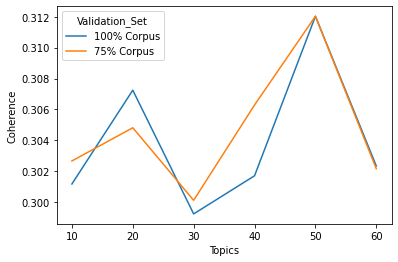

In [29]:
data = model_results.loc[(model_results['Alpha']==alpha)]
data = data[data['Beta']==beta]
sns.lineplot(data=data, x='Topics', y='Coherence', hue='Validation_Set', legend='brief')
# plt.savefig('Images/topic_number_CV.png')

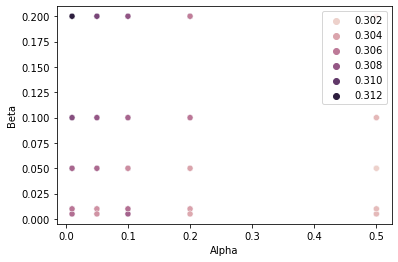

In [33]:
data = model_results.loc[model_results['Topics']==topics]
sns.scatterplot(data=data, x='Alpha', y='Beta', hue='Coherence')
plt.legend(loc='upper right')
# plt.savefig('Images/scatter_alpha_beta_CV.png')

### Performing LDA

In [27]:
# alpha = 0.05
# beta = 1
# topics = 35

In [20]:
# Build LDA model
lda_model = models.LdaMulticore(corpus=corpus,
                                 id2word=id2word,
                                 num_topics=topics,
                                 alpha=alpha,
                                 eta=beta,
                                 random_state=100)
                                 
# Print top 10 words of each topic
pprint(lda_model.print_topics(num_topics=topics))

[(0,
  '0.006*"people" + 0.006*"make" + 0.006*"think" + 0.005*"way" + 0.005*"work" '
  '+ 0.005*"need" + 0.004*"take" + 0.004*"see" + 0.004*"friend" + '
  '0.004*"feel"'),
 (1,
  '0.006*"make" + 0.005*"think" + 0.005*"feel" + 0.004*"lot" + 0.004*"friend" '
  '+ 0.004*"point" + 0.004*"work" + 0.004*"way" + 0.004*"life" + 0.004*"see"'),
 (2,
  '0.006*"think" + 0.006*"feel" + 0.005*"people" + 0.005*"make" + '
  '0.005*"anything" + 0.005*"need" + 0.005*"point" + 0.005*"see" + 0.004*"way" '
  '+ 0.004*"take"'),
 (3,
  '0.006*"work" + 0.006*"way" + 0.006*"need" + 0.005*"people" + 0.005*"think" '
  '+ 0.004*"take" + 0.004*"point" + 0.004*"make" + 0.004*"getting" + '
  '0.004*"help"'),
 (4,
  '0.006*"think" + 0.006*"lot" + 0.005*"way" + 0.005*"make" + 0.005*"people" + '
  '0.005*"feel" + 0.004*"see" + 0.004*"friend" + 0.004*"anything" + '
  '0.004*"need"'),
 (5,
  '0.007*"feel" + 0.006*"way" + 0.005*"think" + 0.005*"let" + 0.005*"make" + '
  '0.004*"anything" + 0.004*"lot" + 0.004*"friend" + 0

In [35]:
lda_results = pyLDAvis.gensim_models._extract_data(lda_model, corpus, id2word)
lda_doc_topic = pd.DataFrame(lda_results['doc_topic_dists'], columns = [f'Topic_{i}' for i in range(0,topics)])
# lda_doc_topic.to_csv('Dataset_TLDRHQ/Results_topic_modeling/lda_doc_topic_CV.csv')
lda_doc_topic

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,...,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44,Topic_45,Topic_46,Topic_47,Topic_48,Topic_49
0,0.000801,0.000801,0.000801,0.000801,0.000801,0.000801,0.000801,0.000801,0.000801,0.000801,...,0.000801,0.000801,0.000801,0.000801,0.000801,0.000801,0.000801,0.000801,0.000801,0.960734
1,0.468698,0.000048,0.099292,0.000048,0.000048,0.000048,0.000048,0.000048,0.000048,0.000048,...,0.000048,0.000048,0.000048,0.000048,0.000048,0.000048,0.000048,0.075659,0.000048,0.000048
2,0.000541,0.000541,0.000541,0.000541,0.744031,0.000541,0.000541,0.229977,0.000541,0.000541,...,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541,0.000541
3,0.000144,0.000144,0.000144,0.000144,0.000144,0.000144,0.000144,0.000144,0.000144,0.262817,...,0.000144,0.000144,0.000144,0.000144,0.000144,0.000144,0.000144,0.000144,0.000144,0.000144
4,0.000426,0.000426,0.000426,0.000426,0.000426,0.000426,0.000426,0.000426,0.000426,0.000426,...,0.000426,0.000426,0.000426,0.000426,0.000426,0.000426,0.000426,0.979113,0.000426,0.000426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40276,0.000202,0.000202,0.000202,0.000202,0.299709,0.000202,0.000202,0.000202,0.000202,0.000202,...,0.000202,0.000202,0.000202,0.000202,0.000202,0.000202,0.000202,0.000202,0.000202,0.000202
40277,0.000426,0.000426,0.000426,0.000426,0.000426,0.000426,0.000426,0.000426,0.000426,0.000426,...,0.000426,0.000426,0.979134,0.000426,0.000426,0.000426,0.000426,0.000426,0.000426,0.000426
40278,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,...,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180,0.000180
40279,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,...,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184


In [36]:
x=lda_model.show_topics(num_topics=topics, num_words=10, formatted=False)
topics_words = [(tp[0], [wd for wd in tp[1]]) for tp in x]

In [39]:
lda_topic_term = pd.DataFrame(topics_words, columns=['Topic', 'other'])#.transpose()
lda_topic_term = lda_topic_term.explode('other')
lda_topic_term[f'Top{word_number}Word'] = lda_topic_term['other'].apply(lambda x: x[0])
lda_topic_term['Score'] = lda_topic_term['other'].apply(lambda x: x[1])
lda_topic_term.drop('other', axis=1, inplace=True)
lda_topic_term.set_index(['Topic', f'Top{word_number}Word'], inplace=True)
# lda_topic_term.to_csv('Dataset_TLDRHQ/Results_topic_modeling/lda_topic_term_cv.csv')
lda_topic_term.head(20)

Score
Topic Top10Word          
0     people     0.006476
      make       0.006464
      think      0.005886
      way        0.005062
      work       0.004934
      need       0.004512
      take       0.004422
      see        0.004334
      friend     0.004197
      feel       0.004126
1     make       0.005896
      think      0.005468
      feel       0.004897
      lot        0.004266
      friend     0.004263
      point      0.004202
      work       0.004014
      way        0.003892
      life       0.003842
      see        0.003689

In [38]:
lda_topic_term.reset_index(inplace=True)
lda_topic_term['test'] = list(range(0,10))*topics
lda_top_terms = pd.pivot(lda_topic_term, index='test', columns='Topic', values=f'Top{word_number}Word')
lda_top_terms.reset_index(inplace=True)
lda_top_terms.drop('test', axis=1, inplace=True)
# lda_top_terms.to_csv('Dataset_TLDRHQ/Results_topic_modeling/lda_top_terms_CV.csv')
lda_top_terms

Topic,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,people,make,think,work,think,feel,way,make,make,make,...,people,think,think,feel,see,think,way,make,think,way
1,make,think,feel,way,lot,way,think,work,see,think,...,think,make,see,think,people,people,make,people,make,see
2,think,feel,people,need,way,think,make,think,think,people,...,make,way,people,see,life,see,think,see,people,think
3,way,lot,make,people,make,let,people,people,way,need,...,feel,see,make,make,way,way,see,friend,lot,friend
4,work,friend,anything,think,people,make,see,point,lot,way,...,lot,game,work,way,make,thought,anything,work,feel,kind
5,need,point,need,take,feel,anything,friend,friend,friend,feel,...,see,made,way,take,think,lot,people,need,way,people
6,take,work,point,point,see,lot,everything,way,made,friend,...,friend,lot,feel,people,feel,make,take,think,take,make
7,see,way,see,make,friend,friend,getting,life,people,getting,...,take,people,made,lot,find,life,friend,thought,come,everything
8,friend,life,way,getting,anything,see,lot,anything,take,lot,...,way,work,take,work,work,look,need,life,guy,need
9,feel,see,take,help,need,people,anything,help,let,work,...,someone,need,friend,tell,getting,problem,work,come,point,feel


In [31]:
coherence = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass').get_coherence()
print(coherence)

-1.2883266383763678


In [24]:
lda_viz = gensimvis.prepare(lda_model, corpus, id2word)
lda_viz

C:\Users\gianl\AppData\Roaming\Python\Python39\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.012683  0.003840       1        1  7.108387
24    -0.014556 -0.000621       2        1  6.138955
26    -0.011137  0.002502       3        1  5.748334
47    -0.004632  0.003189       4        1  5.519004
31    -0.005510  0.002292       5        1  3.535978
25    -0.009677 -0.000949       6        1  3.511633
27     0.005910 -0.000782       7        1  2.966938
39    -0.008094 -0.002080       8        1  2.924084
7     -0.000215  0.002010       9        1  2.889428
36    -0.003553  0.001651      10        1  2.844805
19    -0.002865  0.000764      11        1  2.757126
6      0.000140 -0.001347      12        1  2.144135
48     0.005405 -0.000153      13        1  2.141685
42     0.005518  0.001773      14        1  2.120060
4     -0.001125 -0.001270      15        1  2.015882
46    -0.001729 -0.005572      16        1  1.957112
3      0.001897  0.003243      17        1  1.896109
12    -0.003937  0.003206      18        1  1.839359
30    -0.005412  0.004809      19        1  1.787216
40    -0.004366  0.001282      20        1  1.785827
14    -0.002952  0.001141      21        1  1.729039
44    -0.005014  0.002696      22        1  1.707372
11    -0.008489  0.001039      23        1  1.693431
5      0.003101 -0.000015      24        1  1.649495
9      0.001912  0.006072      25        1  1.629050
10    -0.006298 -0.001442      26        1  1.627310
28    -0.005976  0.003649      27        1  1.618666
2     -0.001754  0.003949      28        1  1.558475
1     -0.003593  0.005575      29        1  1.510583
34    -0.007190 -0.003650      30        1  1.496154
23     0.001373  0.004550      31        1  1.481206
37     0.010061 -0.000610      32        1  1.397732
17     0.005881  0.006546      33        1  1.263308
8      0.002702 -0.004442      34        1  1.237615
13    -0.001085 -0.002439      35        1  1.234299
18    -0.002713  0.004904      36        1  1.225062
22     0.013035 -0.006625      37        1  1.207831
49    -0.001347 -0.006674      38        1  1.066447
38    -0.003083 -0.000221      39        1  1.020979
16     0.022536  0.015402      40        1  0.992038
15     0.000158 -0.002109      41        1  0.985476
43    -0.005810  0.000169      42        1  0.980647
20     0.007915  0.001048      43        1  0.931579
45     0.011128  0.004287      44        1  0.873535
32     0.009170 -0.007437      45        1  0.814371
35     0.005979 -0.000086      46        1  0.763629
33     0.011519 -0.004658      47        1  0.733452
41     0.014646 -0.003416      48        1  0.711352
21    -0.002827 -0.021639      49        1  0.691025
29     0.007635 -0.013353      50        1  0.536784, topic_info=        Term          Freq         Total Category  logprob  loglift
128     make  12703.000000  12703.000000  Default  30.0000  30.0000
198    think  12602.000000  12602.000000  Default  29.0000  29.0000
214      way  11565.000000  11565.000000  Default  28.0000  28.0000
148   people  11964.000000  11964.000000  Default  27.0000  27.0000
74      feel   9869.000000   9869.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
182  started     31.740284   6845.686279  Topic50  -5.9524  -0.1465
41      come     31.949209   7091.097252  Topic50  -5.9458  -0.1751
488      lot     34.300168   8369.563151  Topic50  -5.8748  -0.2699
140     need     32.006151   8355.295550  Topic50  -5.9440  -0.3374
118     life     29.382138   7541.855032  Topic50  -6.0296  -0.3205

[3935 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
9178      1  0.042984    abit
9178      2  0.128953    abit
9178      3  0.042984    abit
9178      4  0.128953    abit
9178      5  0.042984    abit
...     ...       ...     ...
6206     26  0.034687  zoning
6206     28  0.034687  zoning
6206     29  0.034687  zoning
6206     35  0.03

## LSA

In [9]:
topics = 20

### Word Embedding - TF-IDF

In [12]:
vectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=(lambda a : a),
    preprocessor=(lambda a : a),
    token_pattern=None,
    min_df=min_df,
    max_df=max_df)

transformed = vectorizer.fit_transform(test['document_normalized'])

transformed.shape # check shape of the document-term matrix (tfidf matrix)

(40281, 13536)

### Peforming LSA

In [13]:
U, Sigma, VT = randomized_svd(transformed, 
                              n_components=topics,
                              n_iter=7,
                              random_state=None)

print(U.shape, Sigma.shape, VT.shape)

(40281, 20) (20,) (20, 13536)


In [14]:
terms = vectorizer.get_feature_names() # list of vocaboulary values

topic_list = []
terms_list = []
score_list = []
terms_only = []

for i, comp in enumerate(VT): # svd_model.components_ is the topic-term matrix
    topic_list.extend([i]*word_number)
    terms_comp = zip(terms, list(np.around(np.array(comp), 2)))
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:word_number]
    terms_list.extend(list(zip(*sorted_terms))[0])
    terms_only.append(list(zip(*sorted_terms))[0])
    score_list.extend(list(zip(*sorted_terms))[1])

lsa_topic_term = pd.DataFrame(list(zip(topic_list, terms_list, score_list)), columns=['Topic', f'Top{word_number}Word', 'Score'])
lsa_topic_term.set_index(['Topic', f'Top{word_number}Word'], inplace=True)
# lsa_topic_term.to_csv('Dataset_TLDRHQ/Results_topic_modeling/lsa_topic_term.csv')
lsa_topic_term

Score
Topic Top10Word       
0     feel        0.12
      friend      0.12
      make        0.12
      think       0.12
      people      0.11
...                ...
19    thinking    0.15
      idea        0.13
      end         0.11
      ask         0.10
      might       0.09

[200 rows x 1 columns]

In [15]:
lsa_top_terms = pd.DataFrame(terms_only).transpose()
# lsa_top_terms.to_csv('Dataset_TLDRHQ/Results_topic_modeling/lsa_top_terms.csv')
lsa_top_terms

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,feel,relationship,went,game,game,game,school,school,guy,help,hundred,school,people,post,hour,people,woman,girlfriend,need,someone
1,friend,friend,home,play,hundred,family,people,class,girl,ask,buy,hundred,hundred,advice,hundred,problem,sex,post,night,anyone
2,make,girl,house,playing,money,parent,class,college,people,try,looking,use,money,question,see,anyone,work,break,use,question
3,think,dating,car,player,play,life,friend,student,money,need,love,class,feel,help,talk,issue,job,college,question,person
4,people,told,room,played,work,play,college,experience,hundred,work,family,girl,started,anyone,night,friend,men,broke,used,thought
5,see,boyfriend,came,friend,buy,playing,everyone,started,car,look,anyone,parent,felt,twenty,twenty,someone,man,school,idea,thinking
6,way,feeling,minute,guy,pay,mom,game,looking,make,tell,find,friend,today,hundred,come,everyone,guy,hour,sex,idea
7,lot,met,took,team,hour,kid,student,girl,pay,come,found,mom,buy,looking,home,group,working,love,help,end
8,relationship,talk,door,girl,playing,love,girl,grade,buy,people,bought,tell,feeling,team,movie,started,asked,need,using,ask
9,work,asked,hour,fun,friend,dad,kid,start,date,play,kid,used,post,thirty,talking,used,question,sex,asked,might


In [16]:
lsa_doc_topic = pd.DataFrame(U, columns = [f'Topic_{i}' for i in range(0,topics)])
# lsa_doc_topic.to_csv('Dataset_TLDRHQ/Results_topic_modeling/lsa_doc_topic.csv')
lsa_doc_topic

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19
0,0.000324,-0.000775,0.000136,0.000138,-0.001143,0.000232,0.000597,0.000427,0.000004,-0.001110,0.000072,-0.000208,-0.000427,0.000101,0.000548,-0.001143,0.001161,-0.000905,0.000383,-0.000137
1,0.010356,0.007441,0.000877,0.000554,-0.002462,0.004483,-0.007496,-0.004876,-0.004542,-0.001987,-0.003691,-0.007997,0.005258,-0.002533,-0.000127,0.003416,-0.000650,-0.004071,0.003061,-0.006855
2,0.003139,-0.000578,-0.002516,-0.004763,0.000878,0.004589,0.003131,0.012309,-0.005706,0.006015,0.003591,0.003959,-0.004047,0.004346,-0.003260,-0.001825,-0.002678,0.000919,-0.001802,0.001809
3,0.006234,-0.003351,-0.009460,-0.002809,-0.008089,0.002141,0.000407,0.002166,0.005866,0.005120,0.001737,0.001361,-0.003421,-0.004103,0.001572,-0.001627,-0.010086,0.001382,0.000186,-0.000045
4,0.003084,-0.000342,0.001187,-0.004374,-0.000199,0.003018,-0.005388,-0.001380,0.000107,0.002533,0.004166,-0.006008,-0.001732,-0.004050,0.001126,0.000995,-0.004455,0.006052,-0.007809,0.000798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40276,0.005428,-0.007782,-0.000136,0.007907,0.006873,0.003623,-0.002381,0.000261,-0.002213,-0.008270,0.002072,-0.005967,0.002717,-0.012160,-0.004548,-0.001830,0.002195,-0.007332,-0.001030,0.002601
40277,0.003139,-0.003985,0.005605,-0.002395,0.008063,-0.006258,-0.005683,0.000020,0.002967,-0.006146,0.015387,0.004389,0.001976,0.003456,0.002287,0.003370,-0.001762,-0.003358,-0.003255,0.006468
40278,0.007664,0.002567,-0.000670,-0.001302,0.007113,-0.009489,-0.001386,0.002360,0.000290,-0.000188,-0.004065,0.001741,-0.013119,-0.004353,0.007694,-0.003274,0.009335,-0.002541,0.006475,0.006564
40279,0.003446,-0.004008,0.003059,-0.000184,-0.003368,-0.003031,-0.003287,-0.000127,0.002083,0.000976,-0.001383,-0.003953,-0.004385,0.004176,0.000859,-0.006056,-0.008395,0.006754,-0.000921,0.000352


#### Examples

In [33]:
processed = pd.read_json('./Dataset_TLDRHQ/processed_dataset/test.json', orient="records", lines=True)
processed = processed[['id', 'document']]
processed['top_topic'] = lsa_doc_topic.idxmax(axis=1)
processed['top_topic'] = lsa_doc_topic.abs().idxmax(axis=1)
processed['document'] = processed['document'].apply(lambda x: ''.join(map(str, x)))
processed.head(10)


In [132]:
pd.set_option('display.max_colwidth', None)
processed.iloc[[2, 14, 34]][['document', 'top_topic']]

,document,top_topic
2,"i can not for the life of me find a school for wing chun , and i am very eager to learn . i know that bad habits can come from learning online but i am getting restless . so if any one would like to help a ( hopefully ) soon to be chunner out , find a school near pleasanton , ca . lineage is n't a big concern of mine right now",Topic_7
14,i have noticed lately that while i may not be interested in a game for its gameplay i want to dig into the story and lore as much as possible . as an example i cant stand the puzzle platforming or multiplayer aspects of splatoon but the lore and characters are super interesting to me ... i want to enjoy those parts of it but have no desire to actually play the game .,Topic_3
34,"since im using a ipad pro with a apple pencil for my work and my studies i had this cool idea of sketching little things and put them later on as wallpaper on my desktop but i ve tested some free apps like adobe sketch but sadly in all these apps , the screen resolution / format did nt fit my dektops one . so my sketch gets either cut off or i have like two big black bars on my desktop . so maybe you know a sketching / drawing app where i can change the resolution or where the format fits my desktop . im using a 1080p monitor btw . i appreciate every suggestion :d",Topic_13


In [133]:
lsa_top_terms.columns =[f'Topic_{i}' for i in range(0,topics)]
lsa_top_terms[['Topic_7','Topic_3', 'Topic_13']]

,Topic_7,Topic_3,Topic_13
0,school,game,post
1,class,play,advice
2,college,playing,question
3,student,player,help
4,experience,played,anyone
5,started,friend,twenty
6,looking,guy,hundred
7,girl,team,looking
8,grade,girl,team
9,start,fun,thirty
